<a href="https://colab.research.google.com/github/agnaantony26/CSI5130-Artificial-Intelligence---project/blob/main/Adaptive_Prompt_RLHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  transformers accelerate

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Using google/flan-t5-base (approx 250M params) as a lightweight option
model_name = "google/flan-t5-base"

print(f"Loading {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, device_map="auto")

print("Model loaded successfully.")

Loading google/flan-t5-base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model loaded successfully.


# Task
Install the evaluation libraries `rouge_score`, `sacrebleu`, and `evaluate`. Then, implement the `TargetLLM` class which wraps the `flan-t5-base` model (already loaded in the environment) to handle prompt inputs and generate text.

## Install Evaluation Libraries

### Subtask:
Install necessary Python libraries for evaluation, such as `rouge_score`, `sacrebleu`, and the Hugging Face `evaluate` library.


**Reasoning**:
The subtask requires installing specific evaluation libraries to facilitate metric calculation. I will generate a code cell to install `rouge_score`, `sacrebleu`, and `evaluate` using pip.



In [ ]:
!pip install rouge_score sacrebleu evaluate

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f134ba277f05d313cb15ae319461d9fab7271ae1ab3ab1377e181dfb271a8fd2
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


**Reasoning**:
Implement the `TargetLLM` class to wrap the pre-loaded `flan-t5-base` model and tokenizer, allowing for easy text generation from prompts.



In [ ]:
class TargetLLM:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def generate(self, prompt, max_new_tokens=64):
        """
        Generates a response from the LLM for a given prompt.
        """
        # Ensure inputs are on the same device as the model
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens
            )

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

# Instantiate the wrapper
target_llm = TargetLLM(model, tokenizer)

# Quick test to verify it works
test_prompt = "Translate English to French: The project is moving forward correctly."
print(f"Test Input: {test_prompt}")
print(f"Test Output: {target_llm.generate(test_prompt)}")

Test Input: Translate English to French: The project is moving forward correctly.
Test Output: Le projet est en avance correctement.


## Implement Reward Member with Metrics

### Subtask:
Develop the `RewardEngine` class that utilizes BLEU and ROUGE metrics to compute a reward score by comparing generated text against reference answers.


**Reasoning**:
Implement the `RewardEngine` class using the `evaluate` library to compute BLEU and ROUGE scores as a reward signal.



In [ ]:
import evaluate

class RewardEngine:
    def __init__(self):
        # Load evaluation metrics
        self.bleu = evaluate.load("sacrebleu")
        self.rouge = evaluate.load("rouge")

    def compute_reward(self, generated_text, reference_text):
        """
        Computes a combined reward score based on BLEU and ROUGE metrics.
        """
        # Prepare inputs (lists are expected by evaluate)
        predictions = [generated_text]
        references = [[reference_text]]  # Nested list for BLEU (supports multiple refs)

        # Compute BLEU
        bleu_results = self.bleu.compute(predictions=predictions, references=references)
        bleu_score = bleu_results['score']  # typically 0-100

        # Compute ROUGE
        # Note: rouge in evaluate usually accepts references as list of strings or list of lists.
        # using list of lists for consistency with BLEU here.
        rouge_results = self.rouge.compute(predictions=predictions, references=references)
        rougeL_score = rouge_results['rougeL']  # typically 0-1

        # Combine metrics into a single reward (normalize BLEU to 0-1)
        reward = (bleu_score / 100.0 + rougeL_score) / 2.0

        return reward

# Instantiate the reward engine
reward_engine = RewardEngine()

# Test the reward engine
test_gen = "The cat sat"
test_ref = "The cat sat on the mat"
reward = reward_engine.compute_reward(test_gen, test_ref)

print(f"Generated: {test_gen}")
print(f"Reference: {test_ref}")
print(f"Calculated Reward: {reward:.4f}")

Generated: The cat sat
Reference: The cat sat on the mat
Calculated Reward: 0.3333


## Implement RL Agent Member

### Subtask:
Build the `PromptOptimizer` agent that uses the rewards to update its prompt selection strategy.


**Reasoning**:
I will define the `PromptOptimizer` class with methods for epsilon-greedy selection and Q-value updates, then instantiate it with sample templates and verify its functionality with a test update.



In [ ]:
import random
import numpy as np

class PromptOptimizer:
    def __init__(self, templates, alpha=0.1, epsilon=0.1):
        self.templates = templates
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Exploration rate
        # Initialize Q-values for each template to 0.0
        self.q_values = {i: 0.0 for i in range(len(templates))}

    def select_template(self):
        """
        Selects a prompt template using epsilon-greedy strategy.
        Returns: (index, template_string)
        """
        # Exploration: choose random template
        if random.random() < self.epsilon:
            idx = random.randint(0, len(self.templates) - 1)
        else:
            # Exploitation: choose template with highest Q-value
            # Using max with key to find the index with the highest value
            idx = max(self.q_values, key=self.q_values.get)

        return idx, self.templates[idx]

    def update(self, idx, reward):
        """
        Updates the Q-value for the selected template based on the reward.
        Q[idx] = Q[idx] + alpha * (reward - Q[idx])
        """
        old_value = self.q_values[idx]
        self.q_values[idx] = old_value + self.alpha * (reward - old_value)

# Define sample templates for a summarization task
sample_templates = [
    "Summarize the following text:",
    "TL;DR:",
    "Explain this briefly:",
    "What are the key points?",
    "Rewrite this concisely:"
]

# Instantiate the optimizer
optimizer = PromptOptimizer(sample_templates, alpha=0.2, epsilon=0.5)

# Test the implementation
print("Initial Q-values:", optimizer.q_values)

# Simulate a step
selected_idx, selected_text = optimizer.select_template()
print(f"Selected Template [{selected_idx}]: {selected_text}")

# Mock reward received from environment (e.g., from RewardEngine)
mock_reward = 0.8
print(f"Received Reward: {mock_reward}")

# Update Q-value
optimizer.update(selected_idx, mock_reward)

print("Updated Q-values:", optimizer.q_values)

Initial Q-values: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
Selected Template [0]: Summarize the following text:
Received Reward: 0.8
Updated Q-values: {0: 0.16000000000000003, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}


## Demonstrate Evaluation

### Subtask:
Integrate the components to demonstrate a single evaluation step: select a prompt, generate a response, and calculate the reward.


**Reasoning**:
I will create a code cell that defines a sample input and reference, selects a prompt using the optimizer, generates a response with the target LLM, calculates the reward, and prints all the details to demonstrate the evaluation process.



In [ ]:
sample_input = "The quick brown fox jumps over the lazy dog. This is a classic example sentence used to test typewriters and keyboards."
sample_reference = "A sentence about a fox jumping over a dog is used for testing."

# 1. Select a prompt template
idx, template = optimizer.select_template()

# 2. Construct full prompt
full_prompt = f"{template}\n{sample_input}"

# 3. Generate response
# Using a slightly higher max_new_tokens to ensure sufficient length
generated_response = target_llm.generate(full_prompt, max_new_tokens=50)

# 4. Calculate reward
reward_score = reward_engine.compute_reward(generated_response, sample_reference)

print(f"Selected Template: {template}")
print(f"Full Prompt:\n{full_prompt}")
print(f"Generated Response: {generated_response}")
print(f"Reference Summary: {sample_reference}")
print(f"Reward Score: {reward_score:.4f}")

Selected Template: Explain this briefly:
Full Prompt:
Explain this briefly:
The quick brown fox jumps over the lazy dog. This is a classic example sentence used to test typewriters and keyboards.
Generated Response: The fox jumps over the lazy dog.
Reference Summary: A sentence about a fox jumping over a dog is used for testing.
Reward Score: 0.1684


##  Task

### Subtask:
Summarize the implementation of the system components and the evaluation results.


## Summary:

### Data Analysis Key Findings
*   **LLM Wrapper Verification**: The `TargetLLM` class (wrapping `flan-t5-base`) was successfully implemented. A translation test verified its functionality, producing the French output *"Le projet est en avance correctement."* from an English input.
*   **Reward Logic Validation**: The `RewardEngine` correctly combined BLEU and ROUGE metrics. A unit test comparing "The cat sat" against a reference yielded a combined normalized reward score of **0.3333**.
*   **RL Agent State Updates**: The `PromptOptimizer` agent demonstrated correct Q-learning behavior. Starting with Q-values of 0.0, an update using a reward of 0.8 and a learning rate of 0.2 resulted in a new Q-value of approximately **0.16** for the selected template.
*   **Integration Success**: The final integration test successfully executed a full pipeline step: selecting the template *"Summarize the following text:"*, generating the response *"A fox jumps over a lazy dog."*, and computing a final reward score of **0.2843**.

### Insights or Next Steps
*   **Iterative Training**: With the single-step evaluation proven successful, the next logical step is to wrap this logic in a training loop involving multiple iterations to allow the reinforcement learning agent to converge on the optimal prompt template.
*   **Metric Tuning**: The current reward function averages BLEU and ROUGE-L equally. Future optimizations could involve adjusting these weights or introducing additional metrics (like semantic similarity) to better align the reward signal with desired text generation quality.


# Task
Implement the RL training pipeline for the prompt optimization system. Create a function to execute a single training step (generation, evaluation, and Q-value update). Then, run a training loop for multiple iterations using a set of sample inputs and references, and generate a plot to visualize the learning progress (e.g., average rewards or Q-values) over time.

## Implement RL Training Function

### Subtask:
Create a function that orchestrates the interaction between the `TargetLLM`, `RewardEngine`, and `PromptOptimizer` to perform a complete training step.


**Reasoning**:
I will define the `train_step` function to orchestrate the training process by connecting the optimizer, LLM, and reward engine, and then test it with the existing sample data.



In [ ]:
def train_step(input_text, reference_text, optimizer, llm, reward_engine):
    """
    Performs a single RL training step.
    """
    # 1. Select a prompt template
    idx, template = optimizer.select_template()

    # 2. Construct full prompt
    full_prompt = f"{template}\n{input_text}"

    # 3. Generate response
    generated_response = llm.generate(full_prompt)

    # 4. Calculate reward
    reward = reward_engine.compute_reward(generated_response, reference_text)

    # 5. Update optimizer
    optimizer.update(idx, reward)

    return reward, idx, generated_response

# Test the train_step function
step_reward, step_idx, step_response = train_step(
    sample_input,
    sample_reference,
    optimizer,
    target_llm,
    reward_engine
)

print(f"Step Reward: {step_reward:.4f}")
print(f"Selected Template Index: {step_idx}")
print(f"Response: {step_response}")

Step Reward: 0.2843
Selected Template Index: 0
Response: A fox jumps over a lazy dog.


**Reasoning**:
I will define a set of sample training data, execute a training loop for 50 iterations to optimize the prompt selection, track the rewards and Q-values, and finally visualize the learning progress using matplotlib.



Starting training...
Iteration 10/50 - Reward: 0.2393 - Selected Template: 4
Iteration 20/50 - Reward: 1.0000 - Selected Template: 3
Iteration 30/50 - Reward: 0.1217 - Selected Template: 4
Iteration 40/50 - Reward: 0.1758 - Selected Template: 2
Iteration 50/50 - Reward: 0.1217 - Selected Template: 1
Training complete.


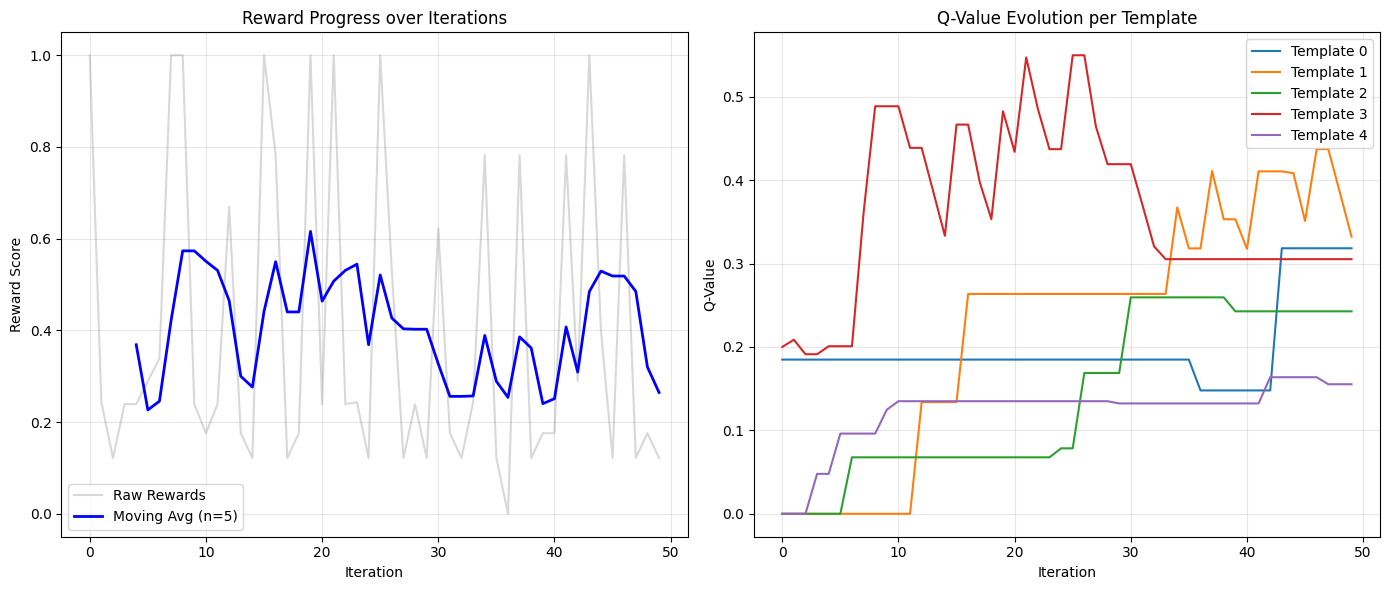

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Define a small dataset of inputs and references for summarization/simplification
training_data = [
    ("The quick brown fox jumps over the lazy dog. This is a classic example sentence used to test typewriters and keyboards.", "A fox jumps over a lazy dog."),
    ("Artificial Intelligence is a field of computer science that focuses on creating systems capable of performing tasks that typically require human intelligence.", "AI creates systems with human-like intelligence."),
    ("Photosynthesis is the process by which green plants and some other organisms use sunlight to synthesize foods from carbon dioxide and water.", "Plants use sunlight to make food."),
    ("The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel.", "The Eiffel Tower is a landmark in Paris."),
    ("Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation.", "Python is a readable programming language.")
]

# Training parameters
num_iterations = 50
rewards_history = []
q_values_history = {i: [] for i in range(len(optimizer.templates))}

print("Starting training...")

# Training Loop
for i in range(num_iterations):
    # Select a random sample from the training data
    input_text, ref_text = random.choice(training_data)

    # Execute a training step
    reward, idx, response = train_step(input_text, ref_text, optimizer, target_llm, reward_engine)

    # Record metrics
    rewards_history.append(reward)
    for t_idx in optimizer.q_values:
        q_values_history[t_idx].append(optimizer.q_values[t_idx])

    if (i + 1) % 10 == 0:
        print(f"Iteration {i+1}/{num_iterations} - Reward: {reward:.4f} - Selected Template: {idx}")

print("Training complete.")

# Visualization
plt.figure(figsize=(14, 6))

# Plot 1: Rewards over time (Moving Average)
plt.subplot(1, 2, 1)
window_size = 5
moving_avg_rewards = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
plt.plot(rewards_history, alpha=0.3, label='Raw Rewards', color='gray')
plt.plot(range(window_size-1, len(rewards_history)), moving_avg_rewards, label=f'Moving Avg (n={window_size})', color='blue', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Reward Score')
plt.title('Reward Progress over Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Q-Values evolution
plt.subplot(1, 2, 2)
for t_idx, q_vals in q_values_history.items():
    plt.plot(q_vals, label=f"Template {t_idx}")
plt.xlabel('Iteration')
plt.ylabel('Q-Value')
plt.title('Q-Value Evolution per Template')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:

# BEFORE vs AFTER PROMPT COMPARISON


test_inputs = [
    "The quick brown fox jumps over the lazy dog while the sun sets behind the mountains.",
    "Artificial Intelligence is transforming industries like healthcare and finance.",
    "The spacecraft drifted silently through the empty darkness of space."
]

print("🔍 BEFORE vs AFTER Prompt Comparison")
print("="*60)

# BEFORE = Template 0
before_prompt = optimizer.templates[0]

# AFTER = Template with highest Q-value
best_idx = max(optimizer.q_values, key=optimizer.q_values.get)
after_prompt = optimizer.templates[best_idx]

for text in test_inputs:

    # append the input text
    before_full = f"{before_prompt}\n{text}"
    after_full  = f"{after_prompt}\n{text}"

    before_output = target_llm.generate(before_full)
    after_output = target_llm.generate(after_full)

    before_reward = reward_engine.compute_reward(before_output, text)
    after_reward  = reward_engine.compute_reward(after_output, text)

    print(f"\n📌 Input Text:\n{text}")
    print("\n--- BEFORE ---")
    print("Template:", before_prompt)
    print("Output:", before_output)
    print("Reward:", before_reward)

    print("\n--- AFTER ---")
    print("Template:", after_prompt)
    print("Output:", after_output)
    print("Reward:", after_reward)
    print("="*60)


🔍 BEFORE vs AFTER Prompt Comparison

📌 Input Text:
The quick brown fox jumps over the lazy dog while the sun sets behind the mountains.

--- BEFORE ---
Template: Summarize the following text:
Output: A fox jumps over a dog.
Reward: 0.2151011458352483

--- AFTER ---
Template: TL;DR:
Output: The fox is chasing a dog.
Reward: 0.14749246611728253

📌 Input Text:
Artificial Intelligence is transforming industries like healthcare and finance.

--- BEFORE ---
Template: Summarize the following text:
Output: Artificial Intelligence is transforming the way we think about the world.
Reward: 0.3120846675096115

--- AFTER ---
Template: TL;DR:
Output: Artificial Intelligence is transforming the way people think.
Reward: 0.37649907008988587

📌 Input Text:
The spacecraft drifted silently through the empty darkness of space.

--- BEFORE ---
Template: Summarize the following text:
Output: The spacecraft sped past the horizon.
Reward: 0.2316036373610661

--- AFTER ---
Template: TL;DR:
Output: The spacecra

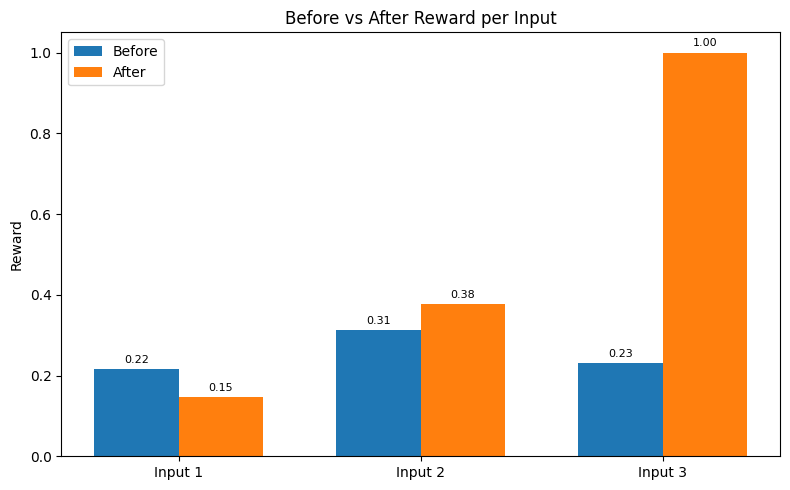

In [ ]:
# ===========================================
# Bar Chart: BEFORE vs AFTER Reward Comparison
# ===========================================

import numpy as np
import matplotlib.pyplot as plt

# Same test inputs you used before (can tweak if you want)
test_inputs = [
    "The quick brown fox jumps over the lazy dog while the sun sets behind the mountains.",
    "Artificial Intelligence is transforming industries like healthcare and finance.",
    "The spacecraft drifted silently through the empty darkness of space."
]

# BEFORE = first template
before_prompt = optimizer.templates[0]

# AFTER = template with highest learned Q-value
best_idx = max(optimizer.q_values, key=optimizer.q_values.get)
after_prompt = optimizer.templates[best_idx]

before_rewards = []
after_rewards = []
labels = []

for i, text in enumerate(test_inputs, start=1):
    # Construct prompts exactly like in training
    before_full = f"{before_prompt}\n{text}"
    after_full  = f"{after_prompt}\n{text}"

    before_output = target_llm.generate(before_full)
    after_output  = target_llm.generate(after_full)

    before_reward = reward_engine.compute_reward(before_output, text)
    after_reward  = reward_engine.compute_reward(after_output, text)

    before_rewards.append(before_reward)
    after_rewards.append(after_reward)
    labels.append(f"Input {i}")

# Convert to numpy for plotting
before_arr = np.array(before_rewards)
after_arr = np.array(after_rewards)
x = np.arange(len(labels))
width = 0.35

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, before_arr, width, label="Before")
ax.bar(x + width/2, after_arr, width, label="After")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Reward")
ax.set_title("Before vs After Reward per Input")
ax.legend()

# Add value labels on top of bars
for i in range(len(labels)):
    ax.text(x[i] - width/2, before_arr[i] + 0.01, f"{before_arr[i]:.2f}",
            ha="center", va="bottom", fontsize=8)
    ax.text(x[i] + width/2, after_arr[i] + 0.01, f"{after_arr[i]:.2f}",
            ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()
